# Network #3.1


## Network Input:  

YEAR,
MONTH,
DAY,
HOUR,
MINUTE,
Latitude,
Longitude,
Distance to Graffiti,
Distance to a Drinking Fountain

## Outputs:

Probability of crime occuring

#### Loading data and creating dataset to be used

##### Importing dataset, creating Date/Time key & adding crime

In [1]:
import pandas as pd
import numpy as np
import pickle

# File loaded from Github Repo
file_path = 'https://raw.githubusercontent.com/NasirKhalid24/ELE494-Project/master/Datasets/final_crime.csv'

df = pd.read_csv(file_path)

# Removing invalid points
df = df[pd.isnull(df['NEIGHBOURHOOD']) != pd.isnull(pd.NaT)]

df = df[['YEAR','MONTH','DAY','HOUR', 'MINUTE', 'Neighbourhood', 'Latitude', 'Longitude', 'Graffiti', 'Drinking_Fountain']] 
print("Shape of Dataset imported for use: " + str(df.shape) + "\n")

print("Sample row")
df.head(1)

Shape of Dataset imported for use: (428141, 10)

Sample row


,YEAR,MONTH,DAY,HOUR,MINUTE,Neighbourhood,Latitude,Longitude,Graffiti,Drinking_Fountain
0,2004,10,8,21.0,0.0,Fairview,49.265076,-123.118474,0.040765,0.402295


In [2]:
# Creating a Key which will be a Date/Time object

print ("------ Adding date-time object as key ------\n")
date_time_col = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR','MINUTE']])

# Make the added Date the index of the dataset
df['DateTimeMix'] = date_time_col
df.set_index('DateTimeMix', inplace=True)

print("Sample row")
df.head(1)

------ Adding date-time object as key ------

Sample row


,YEAR,MONTH,DAY,HOUR,MINUTE,Neighbourhood,Latitude,Longitude,Graffiti,Drinking_Fountain
DateTimeMix,,,,,,,,,,
2004-10-08 21:00:00,2004,10,8,21.0,0.0,Fairview,49.265076,-123.118474,0.040765,0.402295


In [3]:
df['Crime'] = 1
print("Sample row")
df.head(1)

Sample row


,YEAR,MONTH,DAY,HOUR,MINUTE,Neighbourhood,Latitude,Longitude,Graffiti,Drinking_Fountain,Crime
DateTimeMix,,,,,,,,,,,
2004-10-08 21:00:00,2004,10,8,21.0,0.0,Fairview,49.265076,-123.118474,0.040765,0.402295,1


##### Import Neighbourhoods and Function to generate co-ordinates in neighbourhood

In [4]:
# Import a list of all neighbourhoods and their center co-ordinates in Vancouver

nb_file_path = 'https://raw.githubusercontent.com/NasirKhalid24/ELE494-Project/master/Datasets/cov_localareas.csv'

neighbourhoods = pd.read_csv(nb_file_path)
print("List of Neighbourhoods : ")
neighbourhoods

List of Neighbourhoods : 


,MAPID,NAME,Latitude,Longitude
0,SUN,Sunset,49.218650,-123.091376
1,MP,Mount Pleasant,49.263060,-123.099888
2,RP,Riley Park,49.244679,-123.103239
3,CBD,Downtown,49.279255,-123.119137
4,KITS,Kitsilano,49.265663,-123.166947
5,DS,Dunbar-Southlands,49.242361,-123.185280
6,KERR,Kerrisdale,49.225466,-123.157878
7,AR,Arbutus-Ridge,49.245938,-123.160737
8,WPG,West Point Grey,49.265928,-123.202077
9,MARP,Marpole,49.210702,-123.130159


In [5]:
# Given a neighbourhood and a radius this code generates a random point in it and returns co-ordinates

import random
import math

def RandomLatLong(nieghbourhood, radius):
  
  r = radius/111300            
  
  row = neighbourhoods[neighbourhoods['NAME'] == nieghbourhood]

  x0 = float(row['Latitude'])
  y0 = float(row['Longitude'])
  
  u = float(random.uniform(0.0,1.0))
  v = float(random.uniform(0.0,1.0))

  w = r * math.sqrt(u)
  t = 2 * math.pi * v
  x = w * math.cos(t) 
  y = w * math.sin(t)

  xLat  = x + x0
  yLong = y + y0

  return (xLat, yLong)

RandomLatLong('Fairview', 500)

(49.264165144524775, -123.1357318429537)

##### Import Graffiti and Function to get distance from Graffiti

In [6]:
# Import a list of all graffiti locations

gr_file_path = 'https://raw.githubusercontent.com/NasirKhalid24/ELE494-Project/master/Datasets/Graffiti.csv'

graffiti = pd.read_csv(gr_file_path)
print("Number of graffiti instances: " + str(graffiti.shape))
print("Sample row")
graffiti.head(1)

Number of graffiti instances: (8507, 2)
Sample row


,Latitude,Longitude
0,49.22386,-123.090426


In [7]:
# Convert all coordinates to radians for easier calculations later
graffiti = graffiti.apply(np.radians)
print("Sample row")
print(graffiti.head(1))
graffiti = graffiti.values

Sample row
   Latitude  Longitude
0  0.859118  -2.148333


In [8]:
def DistanceToGraffiti(lat1, lon1):
    r = 6371 # Radius of earth in kilometers
    
    coordinates = np.array([np.radians(lat1), np.radians(lon1)])
    diff_array = graffiti - coordinates
    
    # Applying the haversine formula as array functions for speed
    a = np.square(np.sin(diff_array[:, 0]/2.0)) + np.cos(coordinates[0]) * np.cos(graffiti[:, 0]) * np.square(np.sin(diff_array[:, 1]/2.0))
    c = 2 * np.arcsin(np.sqrt(a)) 
    return np.amin(c)*r
with open('DistanceToGraffiti.pkl', 'wb') as file:
    pickle.dump(DistanceToGraffiti, file)
DistanceToGraffiti(49.2650765,-123.1184743)

0.040765350813073524

##### Import Drinking fountain and Function to get distance from Drinking fountain

In [9]:
# Import a list of all drinking fountain locations

df_file_path = 'https://raw.githubusercontent.com/NasirKhalid24/ELE494-Project/master/Datasets/drinking_fountains.csv'

drinking = pd.read_csv(df_file_path)
drinking = drinking[['LATITUDE', 'LONGITUDE']]
print("Number of drinking fountains: " + str(drinking.shape))
print("Sample row")
drinking.head(1)

Number of drinking fountains: (240, 2)
Sample row


,LATITUDE,LONGITUDE
0,49.234947,-123.027254


In [10]:
# Convert all coordinates to radians for easier calculations later
drinking = drinking.apply(np.radians)
print("Sample row")
print(drinking.head(1))
drinking = drinking.values

Sample row
   LATITUDE  LONGITUDE
0  0.859312  -2.147231


In [11]:
def DistanceToFountain(lat1, lon1):
    r = 6371 # Radius of earth in kilometers
    
    coordinates = np.array([np.radians(lat1), np.radians(lon1)])
    diff_array = drinking - coordinates
    
    # Applying the haversine formula as array functions for speed
    a = np.square(np.sin(diff_array[:, 0]/2.0)) + np.cos(coordinates[0]) * np.cos(drinking[:, 0]) * np.square(np.sin(diff_array[:, 1]/2.0))
    c = 2 * np.arcsin(np.sqrt(a)) 
    return np.amin(c)*r
with open('DistanceToFountain.pkl', 'wb') as file:
    pickle.dump(DistanceToFountain, file)
DistanceToFountain(49.2650765,-123.1184743)

0.40229507588315133

#### Upsample every 30 minute and add data points

In [12]:
import random

df_extra = df.groupby(level=0).count().resample('30min').asfreq()
df_extra = df_extra[pd.isna((df_extra['HOUR']))]

df_extra['Crime'] = 0
df_extra['YEAR'] = df_extra.index.year
df_extra['MONTH'] = df_extra.index.month
df_extra['DAY'] = df_extra.index.day
df_extra['HOUR'] = df_extra.index.hour
df_extra['MINUTE'] = df_extra.index.minute
df_extra['Neighbourhood'] = [neighbourhoods.sample()['NAME'].values[0] for i in range(0,df_extra.values.shape[0])]
df_extra[['Latitude', 'Longitude']] = df_extra['Neighbourhood'].apply(lambda x: RandomLatLong(x, 500)).apply(pd.Series)
df_extra['Graffiti'] = df_extra.apply(lambda x: DistanceToGraffiti(x['Latitude'], x['Longitude']), axis=1)
df_extra['Drinking_Fountain'] = df_extra.apply(lambda x: DistanceToFountain(x['Latitude'], x['Longitude']), axis=1)

In [13]:
df_extra.head(4)

,YEAR,MONTH,DAY,HOUR,MINUTE,Neighbourhood,Latitude,Longitude,Graffiti,Drinking_Fountain,Crime
DateTimeMix,,,,,,,,,,,
2004-01-01 00:30:00,2004,1,1,0,30,Killarney,49.216819,-123.041007,0.259316,0.621049,0
2004-01-01 01:30:00,2004,1,1,1,30,Victoria-Fraserview,49.222982,-123.063681,0.178694,0.766635,0
2004-01-01 02:00:00,2004,1,1,2,0,Kensington-Cedar Cottage,49.246298,-123.072160,0.162834,0.209467,0
2004-01-01 02:30:00,2004,1,1,2,30,Sunset,49.221364,-123.090929,0.083349,0.435824,0


In [14]:
print("Shape of Original Dataset: " + str(df.shape) + "\n")

df = df.append(df_extra)

print("Shape of Upsampled Dataset with No crime values: " + str(df.shape) + "\n")

Shape of Original Dataset: (428141, 11)

Shape of Upsampled Dataset with No crime values: (542276, 11)



/tmp/ipykernel_6402/4058691887.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_extra)


#### Extract network input and output and make sets

In [15]:
Y = df['Crime'].values
X = df[['YEAR','MONTH','DAY','HOUR', 'MINUTE', 'Latitude', 'Longitude', 'Graffiti', 'Drinking_Fountain']].values

In [16]:
X[0]

array([ 2.00400000e+03,  1.00000000e+01,  8.00000000e+00,  2.10000000e+01,
        0.00000000e+00,  4.92650765e+01, -1.23118474e+02,  4.07653508e-02,
        4.02295076e-01])

In [17]:
Y[0]

1

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)
X = scaler.transform(X)
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)
print(X[0])

[0.         0.81818182 0.23333333 0.91304348 0.         0.57072995
 0.52565412 0.01773122 0.17916438]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

print("Training Data Size: " + str(X_train.shape))
print("Testing Data Size:" + str(X_test.shape))
print("Training Label Size: " + str(Y_train.shape))
print("Testing Label Size: " + str(Y_test.shape))

Training Data Size: (363324, 9)
Testing Data Size:(178952, 9)
Training Label Size: (363324,)
Testing Label Size: (178952,)


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot loss and accuracy vs epochs
def loss_curve(history):
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  x_axis     = range(1, len(history.history['loss'])+1)
  
  plt.figure()
  plt.plot(x_axis, train_loss, label="Training Loss")
  plt.plot(x_axis, val_loss, label="Validation Loss")
  plt.ylabel('Loss Value')
  plt.xlabel('Epochs')
  plt.title('Epochs vs Loss')
  plt.legend()
  
def accuracy(history):
  acc  = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  x_axis     = range(1, len(history.history['accuracy'])+1)
  
  plt.figure()
  plt.plot(x_axis, np.dot(acc,100), label="Accuracy")
  plt.plot(x_axis, np.dot(val_acc, 100), label="Validation Accuracy")
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.title('Epochs vs Accuracy')
  plt.legend()

#### Training Network

In [21]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

model = Sequential()

model.add(Dense(64, activation='sigmoid', input_shape=(X_train.shape[1], ) ) )
model.add(Dense(128, activation='sigmoid') )
model.add(Dense(512, activation='sigmoid') )
model.add(Dense(128, activation='sigmoid') )
model.add(Dense(64, activation='sigmoid') )


model.add(Dense(1, activation='sigmoid') )

model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()

2023-01-31 16:06:47.145577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 16:06:47.533210: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 16:06:47.533263: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 16:06:48.889271: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 148,993
Trainable params: 148,993
Non-trai

In [22]:
history = model.fit(X_train, Y_train,
          epochs = 50,
          batch_size=128,
          validation_split=0.1,
          verbose = 1)

Epoch 1/50
2555/2555 [==============================] - 30s 11ms/step - loss: 0.5155 - accuracy: 0.7895 - val_loss: 0.5128 - val_accuracy: 0.7910
Epoch 2/50
2555/2555 [==============================] - 25s 10ms/step - loss: 0.5150 - accuracy: 0.7895 - val_loss: 0.5127 - val_accuracy: 0.7910
Epoch 3/50
2555/2555 [==============================] - 26s 10ms/step - loss: 0.5150 - accuracy: 0.7895 - val_loss: 0.5126 - val_accuracy: 0.7910
Epoch 4/50
2555/2555 [==============================] - 24s 10ms/step - loss: 0.5150 - accuracy: 0.7895 - val_loss: 0.5127 - val_accuracy: 0.7910
Epoch 5/50
2555/2555 [==============================] - 23s 9ms/step - loss: 0.5150 - accuracy: 0.7895 - val_loss: 0.5127 - val_accuracy: 0.7910
Epoch 6/50
2555/2555 [==============================] - 23s 9ms/step - loss: 0.5149 - accuracy: 0.7895 - val_loss: 0.5126 - val_accuracy: 0.7910
Epoch 7/50
2555/2555 [==============================] - 23s 9ms/step - loss: 0.5149 - accuracy: 0.7895 - val_loss: 0.5126 - va

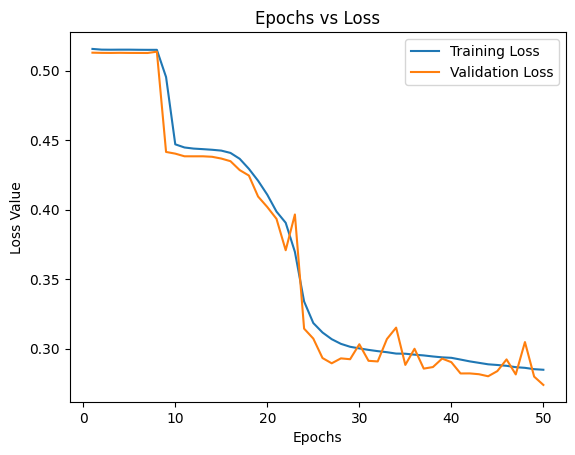

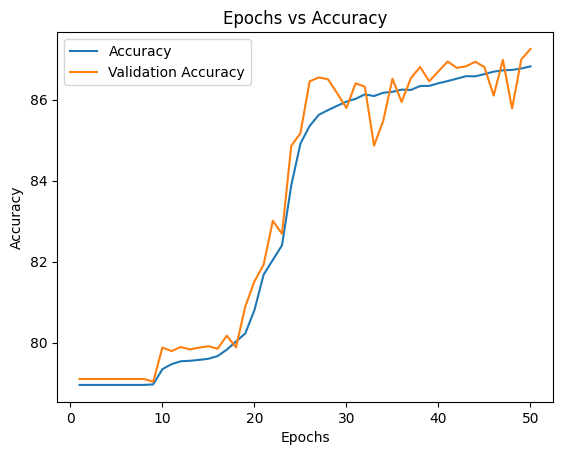

In [23]:
loss_curve(history)
accuracy(history)

In [24]:
print("Evaluating on Test Dataset")
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Evaluating on Test Dataset
accuracy: 87.00%


In [25]:
# Predicting for random year/month/day/hour

test = np.array([[2019, 2, 11, 1,25, 49.237994, -123.083282, DistanceToGraffiti(49.237994, -123.083282), DistanceToFountain(49.237994, -123.083282)]])
test = scaler.transform(test)
ans = model.predict(test)
ans

1/1 [==============================] - 0s 244ms/step


array([[0.9950637]], dtype=float32)

In [26]:
# Predicting for another random year/month/day/hour

test = np.array([[2012, 6, 4, 22, 2, 49.238019, -123.163815, DistanceToGraffiti(49.238019, -123.163815), DistanceToFountain(49.238019, -123.163815)]])
test = scaler.transform(test)
ans = model.predict(test)
ans

1/1 [==============================] - 0s 59ms/step


array([[0.96351725]], dtype=float32)

In [27]:
# Predict crime in a location over the whole day
for i in range(0, 25):
  test = np.array([[2012, 6, 4, i, 2, 49.284645, -123.136306, DistanceToGraffiti(49.284645, -123.136306), DistanceToFountain(49.284645, -123.136306)]])
  test = scaler.transform(test)
  ans = model.predict(test)
  print("Likelihood of crime at " + str(i) + " hour: " + str(ans[0][0]*100) + " %") 

1/1 [==============================] - 0s 76ms/step
Likelihood of crime at 0 hour: 99.93488192558289 %
1/1 [==============================] - 0s 53ms/step
Likelihood of crime at 1 hour: 99.83712434768677 %
1/1 [==============================] - 0s 55ms/step
Likelihood of crime at 2 hour: 99.15645718574524 %
1/1 [==============================] - 0s 52ms/step
Likelihood of crime at 3 hour: 97.16687798500061 %
1/1 [==============================] - 0s 48ms/step
Likelihood of crime at 4 hour: 94.05348896980286 %
1/1 [==============================] - 0s 53ms/step
Likelihood of crime at 5 hour: 91.27399921417236 %
1/1 [==============================] - 0s 50ms/step
Likelihood of crime at 6 hour: 91.42061471939087 %
1/1 [==============================] - 0s 54ms/step
Likelihood of crime at 7 hour: 95.66274285316467 %
1/1 [==============================] - 0s 50ms/step
Likelihood of crime at 8 hour: 97.69136309623718 %
1/1 [==============================] - 0s 51ms/step
Likelihood of crime a

In [28]:
# Predict crime in a location over the whole day
for i in range(0, 25):
  test = np.array([[2012, 6, 4, i, 2, 49.289599, -123.136649, DistanceToGraffiti(49.289599, -123.136649), DistanceToFountain(49.289599, -123.136649)]])
  test = scaler.transform(test)
  ans = model.predict(test)
  print("Likelihood of crime at " + str(i) + " hour: " + str(ans[0][0]*100) + " %") 

1/1 [==============================] - 0s 53ms/step
Likelihood of crime at 0 hour: 99.93574023246765 %
1/1 [==============================] - 0s 45ms/step
Likelihood of crime at 1 hour: 99.84392523765564 %
1/1 [==============================] - 0s 49ms/step
Likelihood of crime at 2 hour: 99.3400514125824 %
1/1 [==============================] - 0s 50ms/step
Likelihood of crime at 3 hour: 98.15558791160583 %
1/1 [==============================] - 0s 47ms/step
Likelihood of crime at 4 hour: 96.46177291870117 %
1/1 [==============================] - 0s 52ms/step
Likelihood of crime at 5 hour: 94.97777819633484 %
1/1 [==============================] - 0s 48ms/step
Likelihood of crime at 6 hour: 95.2345609664917 %
1/1 [==============================] - 0s 49ms/step
Likelihood of crime at 7 hour: 97.64660000801086 %
1/1 [==============================] - 0s 50ms/step
Likelihood of crime at 8 hour: 98.69188666343689 %
1/1 [==============================] - 0s 48ms/step
Likelihood of crime at 

In [29]:
# Predict crime in a location over the whole day
for i in range(0, 25):
  test = np.array([[2012, 6, 4, i, 2, 49.244879, -123.085077, DistanceToGraffiti(49.244879, -123.085077), DistanceToFountain(49.244879, -123.085077)]])
  test = scaler.transform(test)
  ans = model.predict(test)
  print("Likelihood of crime at " + str(i) + " hour: " + str(ans[0][0]*100) + " %") 

1/1 [==============================] - 0s 54ms/step
Likelihood of crime at 0 hour: 99.78669285774231 %
1/1 [==============================] - 0s 43ms/step
Likelihood of crime at 1 hour: 97.76644110679626 %
1/1 [==============================] - 0s 44ms/step
Likelihood of crime at 2 hour: 77.29945778846741 %
1/1 [==============================] - 0s 50ms/step
Likelihood of crime at 3 hour: 55.82380294799805 %
1/1 [==============================] - 0s 48ms/step
Likelihood of crime at 4 hour: 44.87149119377136 %
1/1 [==============================] - 0s 43ms/step
Likelihood of crime at 5 hour: 37.81711757183075 %
1/1 [==============================] - 0s 45ms/step
Likelihood of crime at 6 hour: 35.92503070831299 %
1/1 [==============================] - 0s 44ms/step
Likelihood of crime at 7 hour: 48.89180064201355 %
1/1 [==============================] - 0s 44ms/step
Likelihood of crime at 8 hour: 71.65349125862122 %
1/1 [==============================] - 0s 45ms/step
Likelihood of crime a

In [30]:


pickle.dump(model, open('model.pkl', 'wb'))


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-01-31 16:30:53      1223704
config.json                                    2023-01-31 16:30:53         3114
metadata.jso

In [31]:
with open("model.pkl", "rb") as file:
    model1 = pickle.load(file)

inputs = model1.input_names
print(inputs)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-01-31 16:30:52      1223704
config.json                                    2023-01-31 16:30:52         3114
metadata.json                                  2023-01-31 16:30:52           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.....

In [32]:
test = np.array([[2012, 6, 4, 22, 2, 49.238019, -123.163815, DistanceToGraffiti(49.238019, -123.163815), DistanceToFountain(49.238019, -123.163815)]])

In [33]:
model1.predict(test)

1/1 [==============================] - 0s 173ms/step


array([[0.18769622]], dtype=float32)

In [34]:
test = np.array([[2012, 6, 4, 22, 2, 49.238019, -123.163815, DistanceToGraffiti(49.238019, -123.163815), DistanceToFountain(49.238019, -123.163815)]])
test = scaler.transform(test)

In [35]:
model1.predict(test)

1/1 [==============================] - 0s 51ms/step


array([[0.96351725]], dtype=float32)

In [36]:
test = np.array([[2019, 2, 11, 1,25, 49.237994, -123.083282, DistanceToGraffiti(49.237994, -123.083282), DistanceToFountain(49.237994, -123.083282)]])

In [37]:
model1.predict(test)

1/1 [==============================] - 0s 50ms/step


array([[0.0946365]], dtype=float32)

In [38]:
with open('DistanceToFountain.pkl', 'rb') as file:
    func = pickle.load(file)


In [39]:
func(49.2650765,-123.1184743)

0.40229507588315133